In [1]:
!curl --remote-name-all https://repository.clarin.is/repository/xmlui/bitstream/handle/20.500.12537/208{/IGC-Parla-22.10.TEI.zip}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 30  595M   30  179M    0     0  35.5M      0  0:00:16  0:00:05  0:00:11 36.7M^C


In [ ]:
!unzip ./IGC-Parla-22.10.TEI.zip

Archive:  ./IGC-Parla-22.10.TEI.zip
   creating: IGC-Parla-22.10.TEI/
   creating: IGC-Parla-22.10.TEI/1935/
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-15-uni-1.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-15.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-18.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-19.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-20.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-21.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-22.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-23.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-25.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-26.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-27.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-02-28.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IGC-Parla_1935-03-01.xml  
  inflating: IGC-Parla-22.10.TEI/1935/IG

In [ ]:
!mv ./IGC-Parla-22.10.TEI ./data

In [ ]:
!mkdir ./processed_data

In [ ]:
# read xml file
import os
import xml.etree.ElementTree as ET
import re

# progress bar
from ipywidgets import IntProgress
from IPython.display import display

all_paths = []
for root, dirs, files in os.walk("./data/"):
    for file in files:

        if file.endswith(".xml"):
             all_paths.append(os.path.join(root, file))

all_paths

# don't include the readme file
all_paths = all_paths[1:]

def read_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    text = []
    for elem in root.iter():
        if elem.text is not None:
            text.append(elem.text.strip())

    extracted_text = " ".join(text)

    # extracted_text = extracted_text[1030:].strip()
    prescript_len = len(extracted_text.split('      ')[0])
    extracted_text = extracted_text[prescript_len:].strip()

    return extracted_text

def save(path, data):
    with open(path, 'w') as f:
        f.write(data)


def clean_dir(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            os.remove(os.path.join(root, file))

clean_dir('./processed_data')

max_count = len(all_paths)

f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar

for path in all_paths:
    # parse data
    data = read_xml(path)

    # remove year date with regex
    path = re.sub(r'\d{4}/', '', path)
    path = path.replace('./data/', './processed_data/').replace('.xml', '.txt')
    
    # save data
    save(path, data)

    f.value += 1 # signal to increment the progress bar

IntProgress(value=0, max=19254)

In [2]:
!pip install torchinfo
!pip install tokenizers

  Using cached torchinfo-1.8.0-py3-none-any.whl (23 kB)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

from tqdm.auto import tqdm

from pathlib import Path

import matplotlib.pyplot as plt

from tokenizers import Tokenizer
from tokenizers.models import BPE
import tokenizers.pre_tokenizers as pre_tokenizers
import tokenizers.processors as processors
import tokenizers.decoders as decoders
from tokenizers.trainers import BpeTrainer

from torchinfo import summary

torch.manual_seed(1357)

In [4]:
data[:100], data[:100]

NameError: name 'data' is not defined

# BPE Tokenizer

In [5]:
import os

all_paths = []
for root, dirs, files in os.walk("./processed_data"):
    for file in files:
        if file.endswith(".txt"):
             all_paths.append(os.path.join(root, file))

tokenizer_path = Path('./tokenizer/')
tokenizer_path.mkdir(exist_ok=True)

tokenizer = Tokenizer(BPE())

tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
tokenizer.decoder = decoders.ByteLevel()
trainer = BpeTrainer(special_tokens=['<|endoftext|>'], min_frequency=2)

# tokenizer.train_from_iterator([data], trainer=trainer, length=len(data))
tokenizer.train(all_paths, trainer=trainer)

# tokenizer.train(['/kaggle/input/shakespeare-full-text/shakespeare.txt'],trainer)
tokenizer.save(str(tokenizer_path / 'parliament.json'))

# Config

In [6]:
# larger model

@dataclass
class Config:
    
    block_size = 256 # context-length
    batch_size = 64 # mini-batch size
    
    vocab_size = tokenizer.get_vocab_size()
    
    train_size = 0.9 
    
    n_embed = 384
    n_heads = 6
    head_size = n_embed // n_heads # computes to 384/6=64
    
    n_layers = 3
    
    # train_iters = 20
    # val_iters = 2
    train_iters = 5000 # no. of batches to train on
    val_iters = 500 # no. of batches to validate on every eval_intervals
    
    eval_interval = 1000 # validate after every eval_interval iterations while training
    
    lr = 5e-4
    
    attn_dropout = 0.2
    block_dropout = 0.2
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
Config.device, Config.vocab_size

('cuda', 30000)

# Dataset

In [7]:
import os

class ParliamentDataset:
    def __init__(self, Config, is_test=False) -> None:
        all_paths = []
        for root, dirs, files in os.walk("processed_data"):
            for file in files:
                if file.endswith(".txt"):
                    all_paths.append(os.path.join(root, file))

        self.data = ""

        for file_path in all_paths:
            with open(file_path,'r',encoding='utf-8') as f:
                _data = f.read()
        self.data += _data
        
        self.tokenizer = Tokenizer.from_file('./tokenizer/parliament.json')
        
        self.full_data = torch.tensor(self.tokenizer.encode(self.data).ids, dtype=torch.long)
        
        self.is_test = is_test
        if self.is_test:
            self.data = self.full_data[int(Config.train_size*len(self.full_data)):]
        else:
            self.data = self.full_data[:int(Config.train_size*len(self.full_data))]

        self.block_size = Config.block_size
        self.batch_size = Config.batch_size

    def __len__(self) -> int:
        return len(self.data)

    def get_block_size(self) -> int:
        return self.block_size

    def get_vocab_size(self) -> int:
        return self.tokenizer.get_vocab_size()

    def __next__(self):
        ix = torch.randint(len(self.data) - self.block_size, (self.batch_size,))
        x = torch.stack([self.data[i:i+self.block_size] for i in ix])
        y = torch.stack([self.data[i+1:i+self.block_size+1] for i in ix])
        return x,y

---

# **GPT Model**

## Single Attention Head

In [8]:
class AttentionHead(nn.Module):
    def __init__(self, Config):
        super().__init__()

        self.block_size = Config.block_size
        self.n_embed = Config.n_embed
        self.head_size = Config.head_size
        
        self.key = nn.Linear(self.n_embed, self.head_size, bias=False)
        self.query = nn.Linear(self.n_embed, self.head_size, bias=False)
        
        self.value = nn.Linear(self.n_embed, self.head_size, bias=False)

        self.register_buffer(
            'tril',
            torch.tril(torch.ones(self.block_size,self.block_size))
        )
        
        self.dropout = nn.Dropout(Config.attn_dropout)

    def forward(self, x):

        B,T,C = x.shape

        k = self.key(x)
        q = self.query(x)

        wei = q@k.transpose(-2,-1) * (C ** 0.5)
        wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        
        v = self.value(x)
        out = wei @ v
        
        return out

## MultiHead Attention

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.n_heads = Config.n_heads
        self.head_size = Config.head_size
        
        self.heads = nn.ModuleList([AttentionHead(Config) for _ in range(self.n_heads)])
        
        self.projection = nn.Linear(Config.n_embed, Config.n_embed)
        
        self.dropout = nn.Dropout(Config.attn_dropout)
    
    def forward(self,x):
        x = torch.cat([h(x) for h in self.heads],dim=-1)
        x = self.projection(x)
        x = self.dropout(x)
        return x

## Feed Forward Layer

# Transformer Block

In [10]:
class TransformerBlock(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.attn = MultiHeadAttention(Config)
        self.ff = FeedForward(Config)
        self.ln1 = nn.LayerNorm(Config.n_embed)
        self.ln2 = nn.LayerNorm(Config.n_embed)

    def forward(self,x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        
        return x

## GPT Model

In [11]:
class ISLParliamentGPT(nn.Module):
    def __init__(self,Config):
        super().__init__()
        
        self.n_embed = Config.n_embed
        self.block_size = Config.block_size
        
        self.token_embedding_table = nn.Embedding(Config.vocab_size,self.n_embed)
        self.pos_embedding_table = nn.Embedding(self.block_size, self.n_embed)
        
        self.blocks = nn.Sequential(
            *[TransformerBlock(Config)]*Config.n_layers,
            nn.LayerNorm(self.n_embed)
        )

        self.lm_head = nn.Linear(self.n_embed,Config.vocab_size)
        
    def forward(self,idx):
        
        B,T = idx.shape
        
        token_embs = self.token_embedding_table(idx)
        pos_embs = self.pos_embedding_table(torch.arange(T,device=Config.device))
        
        
        x = token_embs + pos_embs
        x = self.blocks(x)
        logits = self.lm_head(x)
        
        return logits

        
    def generate(self,idx,total):
        for _ in range(total):
            idx_cond = idx[:, -self.block_size:]
            logits= self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
            

In [12]:
class FeedForward(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(Config.n_embed,Config.n_embed * 4),
            nn.ReLU(),
            nn.Linear(Config.n_embed * 4, Config.n_embed), # projection
            nn.Dropout(Config.block_dropout)
        )
    def forward(self,x):
        return self.net(x)

# Training

In [13]:
train_ds = ParliamentDataset(Config)
val_ds = ParliamentDataset(Config,is_test=True)

In [14]:
lm = ISLParliamentGPT(Config)
lm = lm.to(device=Config.device)

In [15]:
summary(lm,input_size=(Config.batch_size, Config.block_size),dtypes=[torch.long],depth=5,)

Layer (type:depth-idx)                        Output Shape              Param #
ISLParliamentGPT                              [64, 256, 30000]          --
├─Embedding: 1-1                              [64, 256, 384]            11,520,000
├─Embedding: 1-2                              [256, 384]                98,304
├─Sequential: 1-3                             [64, 256, 384]            --
│    └─TransformerBlock: 2-1                  [64, 256, 384]            --
│    │    └─LayerNorm: 3-1                    [64, 256, 384]            768
│    │    └─MultiHeadAttention: 3-2           [64, 256, 384]            --
│    │    │    └─ModuleList: 4-9              --                        (recursive)
│    │    │    │    └─AttentionHead: 5-1      [64, 256, 64]             73,728
│    │    │    │    └─AttentionHead: 5-2      [64, 256, 64]             73,728
│    │    │    │    └─AttentionHead: 5-3      [64, 256, 64]             73,728
│    │    │    │    └─AttentionHead: 5-4      [64, 256, 64]  

### Optimizer

In [16]:
optim = torch.optim.AdamW(lm.parameters(), lr=Config.lr)

### Loss Function

In [17]:
def loss_fn(logits, targets):
    B,T,C = logits.shape
    logits = logits.view(B*T, C)
    targets = targets.view(B*T)
    loss = F.cross_entropy(logits,targets)
    return loss

# Training Loops

## Validation Loop

averages over `val_iters` mini-batches

In [18]:
@torch.no_grad()
def valid_N_iters():
    val_step_losses = []
    for batch in tqdm(range(Config.val_iters)):
        inputs, targets = next(val_ds)
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        val_step_losses.append(loss.item())
        
        del inputs, targets, loss, logits
    
    val_loss = torch.tensor(val_step_losses).mean()
    print(f'val loss: {val_loss}')
    return val_loss

## Training Loop

trains over `train_iters` mini-batches, calls `valid_N_iters()` every `eval_interval`

In [19]:
def train_N_iters():
    lm.train()
    train_step_losses = []
    val_losses = []
    for batch in tqdm(range(Config.train_iters)):
        optim.zero_grad()
        inputs, targets = next(train_ds)
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        loss.backward()
        optim.step()
        train_step_losses.append(loss.item())
        
        if batch%(Config.train_iters//10)==0 or batch==Config.train_iters-1:
            print(f"\n{'-'*50}\nbatch {batch} train step loss: {loss.item()}")
            print(f"train loss so far: {torch.tensor(train_step_losses).mean()}\n{'-'*50}\n")
            
        if batch%Config.eval_interval==0 or batch==Config.train_iters-1:
            lm.eval()
            val_loss = valid_N_iters()
            lm.train()
            val_losses.append(val_loss.item())
            
            del val_loss
            
        del inputs, targets, loss, logits
        
    return train_step_losses, val_losses

In [20]:
def save_lm():
    state_dict = lm.state_dict()
    save_path = Path('./').resolve() / 'isl_parliament_gpt'
    save_path.mkdir(exist_ok=True)
    model_path = save_path / f'isl_parliament_gpt.pth'
    torch.save(state_dict, model_path)

In [21]:
def train_lm():
    train_step_losses,val_losses = train_N_iters() 
    save_lm()
    return train_step_losses,val_losses

In [22]:
tsl,vl=train_lm()

  0%|          | 0/5000 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.83 GiB (GPU 0; 8.00 GiB total capacity; 5.33 GiB already allocated; 0 bytes free; 5.96 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
tsl_mean = torch.tensor(tsl).mean()
print('Train Loss:',tsl_mean.item())

Train Loss: 1.912103295326233


# Loss Plots

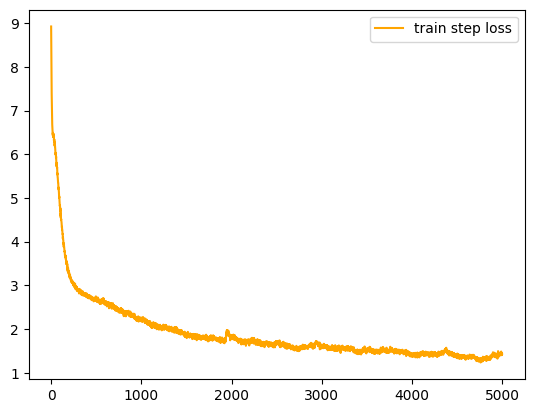

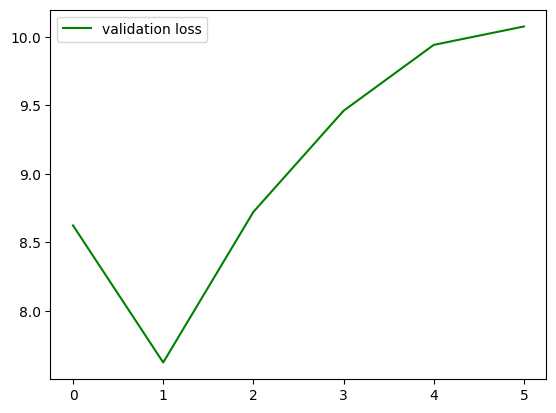

In [ ]:
plt.plot(tsl,label='train step loss',color='orange')
plt.legend()
plt.show()
plt.plot(vl,label='validation loss',color='green')
plt.legend()
plt.show()

# Generating

In [ ]:
generated_texts = []
for length in [100,300,500,700,1000]:
    generated = lm.generate(
    torch.zeros((1,1),dtype=torch.long,device=Config.device)+61, # initial context 61 (i believe its \n)
    total=length
)
    generated = tokenizer.decode(generated[0].cpu().numpy())
    text=f'generated ({length} tokens)\n{"="*50}\n{generated}\n{"="*50}\n\n'
    generated_texts.append(text)
    print(text)

generated (100 tokens)
t á landshlutana herráðherra styðja stækkun tveggja þar með þessari ræðu hæstv. utanríkisráðherra er fyrsti þingmaður algerlega fyrir, segir varðandi skattaráðherra, alveg ótrúlegt á því að vel á að hægja Samfylkingarinnar hafa líka spilju, og skattanefnd taki þær og vel á götunum á auðlefni, skuldina.  Frú forseti, hver annan hvern sparisjóð og vikum til þess að fara til að einhverju hér á fer aftur, og hafi verið mjög li áskilja sér og


generated (300 tokens)
tal.. Og ríkisstjórnin ekki gert. H. Það átti að velta þessu máli. Ég get þetta nú hefur komið inn í umræðunni að inn megin hrödd haustu sem ég geri ég kosið, eins og hún ágætisr og það er ekki er það auðvitað rétt fyrirvarana og þingmaður eru þúsin eru þetta málefnalegrar ef við öll hér til liðs ef við hefðum þá langar til að málið núna þegar við hv. Það er verið í staðinn fyrir þingheimur hv. þingmann um mat í ríkisstjórn sagði áðan og minna á fundi í hendur áfram samninga í gökkanum. þingmann um einhve

In [ ]:
with open('generated.txt','w') as f:
    for text in generated_texts:
        f.write(text)

In [ ]:
input_text = "Kirkjustræti Reykjavik Iceland 2009-12-16     Virðulegi forseti."
input = tokenizer.encode(input_text, add_special_tokens=False)
input_ids = torch.tensor(input.ids, dtype=torch.long, device=Config.device).unsqueeze(0)

input.tokens, input.ids, input_ids

(['K',
  'ir',
  'k',
  'just',
  'r',
  'Ã¦ti',
  'ĠReykja',
  'vik',
  'ĠIceland',
  'Ġ2009',
  '-',
  '1',
  '2',
  '-',
  '1',
  '6',
  'ĠĠ',
  'ĠĠ',
  'ĠVirÃ°ulegi',
  'Ġforseti',
  '.'],
 [29,
  114,
  52,
  4290,
  59,
  449,
  2928,
  4393,
  6219,
  2217,
  3,
  7,
  8,
  3,
  7,
  12,
  2993,
  2993,
  772,
  313,
  4],
 tensor([[  29,  114,   52, 4290,   59,  449, 2928, 4393, 6219, 2217,    3,    7,
             8,    3,    7,   12, 2993, 2993,  772,  313,    4]],
        device='cuda:0'))

In [ ]:


length = 50
generated = lm.generate(
    input_ids,
    total=length
)

generated = tokenizer.decode(generated[0].cpu().numpy())
text=f'generated ({length} tokens)\n{"="*50}\n{generated}\n{"="*50}\n\n'
print(text)

generated (50 tokens)
Kirkjustræti Reykjavik Iceland 2009-12-16     Virðulegi forseti.a. Gæti ekki að reyna að spyrja þingmanninn þessarar ríkisstjórnar sem ég benti svo mikið um Í gær þar gátu menn hétsýn og svo efnahagslífsóknina bæði bréf þar. As-msag til að Íslendingar við séum í.


